<a href="https://colab.research.google.com/github/ys23-lys/ESAA/blob/main/Poverty_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

< Poverty Prediction Challenge >

- 주최: World Bank (세계은행) & DrivenData

- 목표: 제한된 설문(survey) 데이터를 활용하여 각각의 가구별 1인당 일일 소비량 (per-capita consumption)을 예측하고 이를 기반으로 인구 수준의 빈곤율 (poverty rate) 을 다양한 기준(threshold)으로 예측하는 모델 개발

< 실제 세계은행 연구자들이 직면하는 문제 >

✔ 오래된 설문조사에는 자세한 소비 데이터가 있지만

✔ 최근 설문에는 그 정보가 없을 때가 많음

- 이럴 경우 새로운 설문에서 소비량을 직접적으로 측정할 수 없기 때문에
- 머신러닝 모델을 활용해 이를 보간(imputation) 해야 함

> 즉: 과거 잘-레이블된 설문 → 새로운 설문 예측으로 소비량과 빈곤율 추정

< 데이터 구조 >

훈련(train) 데이터

- 여러 연도의 가구 설문 응답
- 각 가구의 1인당 일일 소비량(ground truth)
- 인구 가중치(weights)
- 설문 항목: 인구학, 교육, 주거, 식품 소비, 지리 등

테스트(test) 데이터

- 소비량/빈곤율 라벨 없음
- 기존 모델로 예측해야 함

성능 = 가구-레벨 소비 예측과 빈곤율 예측 오류 기반

< 주요 평가 지표 >
- 가중 평균 오차(metric)

> 빈곤율 예측 오차 → 약 90% 비중

> 가구 소비 예측 오차 → 약 10% 비중

즉, 빈곤율 예측 정확도가 사실상 승부를 가른다고 보면 됨

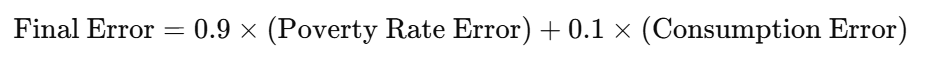

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA

X : Household survey features → 설명 변수

y₁ : Household consumption labels → 1인당 하루 소비액 (USD/day)

y₂ : Survey-level poverty rate labels → 설문 전체 빈곤율 (여러 빈곤선 threshold)

< 전체 순서 >

```
X + y1  → 가구 소비 모델 학습
예측된 소비 → 빈곤율 계산
계산된 빈곤율 ↔ y2 비교 (검증)
```



In [ ]:
X = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_gt.csv')
y2 = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_rates_gt.csv')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab/contest/test_hh_features.csv')

In [ ]:
X.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,100000
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,Yes,No,No,No,No,Yes,Yes,No,No,100000
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,No,Yes,No,No,No,Yes,Yes,No,No,100000
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,100000


In [ ]:
y1.head()

,survey_id,hhid,cons_ppp17
0,100000,100001,25.258402
1,100000,100002,16.996706
2,100000,100003,13.671848
3,100000,100004,7.189475
4,100000,100005,12.308855


In [ ]:
y2.head()

,survey_id,pct_hh_below_3.17,pct_hh_below_3.94,pct_hh_below_4.60,pct_hh_below_5.26,pct_hh_below_5.88,pct_hh_below_6.47,pct_hh_below_7.06,pct_hh_below_7.70,pct_hh_below_8.40,pct_hh_below_9.13,pct_hh_below_9.87,pct_hh_below_10.70,pct_hh_below_11.62,pct_hh_below_12.69,pct_hh_below_14.03,pct_hh_below_15.64,pct_hh_below_17.76,pct_hh_below_20.99,pct_hh_below_27.37
0,100000,0.067364,0.118927,0.169905,0.221865,0.271564,0.319585,0.366329,0.419816,0.471454,0.523798,0.574413,0.623091,0.671263,0.721329,0.773303,0.819770,0.865121,0.909075,0.954239
1,200000,0.059326,0.111560,0.159023,0.211754,0.263100,0.311758,0.356914,0.407631,0.463443,0.512931,0.559361,0.609337,0.659291,0.708043,0.760932,0.809045,0.860350,0.906385,0.952805
2,300000,0.049803,0.100381,0.149502,0.200144,0.250192,0.300211,0.349596,0.399930,0.449845,0.499930,0.550082,0.599926,0.650088,0.699617,0.750341,0.800111,0.850081,0.899974,0.949988


In [ ]:
test.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id
0,400001,1,320,4,567.80914,Female,4,0,1,0,...,No,No,No,No,No,Yes,Yes,Yes,No,400000
1,400002,1,480,4,561.70367,Female,6,0,1,1,...,Yes,No,No,No,No,Yes,Yes,Yes,No,400000
2,400003,1,320,4,183.16423,Male,4,0,0,0,...,Yes,No,Yes,No,Yes,Yes,No,Yes,No,400000
3,400004,1,320,4,696.02411,Male,4,0,0,1,...,Yes,Yes,No,No,No,Yes,Yes,No,No,400000
4,400005,1,320,4,286.95731,Male,4,0,0,1,...,Yes,No,No,No,No,No,Yes,No,No,400000


# Processing

< 전처리 순서 >


```
X, y1 merge
split
X / y 분리
결측치 처리 fit, transform
```



## X, y1 merge

In [ ]:
train = X.merge(
    y1,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)

In [ ]:
train.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [ ]:
train.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

| 컬럼          | 의미         |
| ----------- | ---------- |
| `hhid`      | 가구 ID      |
| `survey_id` | 설문 ID      |
| `com`       | 가구원 식별용 코드 |
| `weight`    | 표본 가중치     |
| `strata`    | 층화 표본 변수   |
| ------------------------- | --------- |
| `hsize`                   | 가구원 수     |
| `num_children5/10/18`     | 연령대별 아동 수 |
| `num_adult_male / female` | 성인 남/여 수  |
| `num_elderly`             | 고령자 수     |
| `age`                     | 가구주 연령    |
| `male`                    | 가구주 성별    |
| ----------------------------- | -------- |
| `owner`                       | 주택 소유 여부 |
| `dweltyp`                     | 주거 형태    |
| `water`, `water_source`       | 물 공급     |
| `toilet`, `sanitation_source` | 위생 시설    |
| `sewer`, `elect`              | 하수/전기    |
| ------------------------------ | ----------- |
| `employed`                     | 고용 여부       |
| `sworkership`                  | 고용 형태       |
| `share_secondary`              | 2차 산업 종사 비율 |
| `educ_max`                     | 최고 학력       |
| `sector1d`                     | 산업 분류       |
| `fsworkership`, `any_nonagric` | 직업 특성       |
| `urban`                        | 도시/농촌       |
| `region1~7`                    | 지역 더미       |
| ------------------------------ | -------------------- |
| `consumed100` ~ `consumed5000` | 특정 품목 소비 여부 (Yes/No) |
| ------------------------------ | -------------------- |
| `cons_ppp17` | **1인당 하루 소비액 (정답 y1)** |


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104234 entries, 0 to 104233
Data columns (total 89 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   hhid               104234 non-null  int64  
 1   com                104234 non-null  int64  
 2   weight             104234 non-null  int64  
 3   strata             104234 non-null  int64  
 4   utl_exp_ppp17      104149 non-null  float64
 5   male               104234 non-null  object 
 6   hsize              104234 non-null  int64  
 7   num_children5      104234 non-null  int64  
 8   num_children10     104234 non-null  int64  
 9   num_children18     104234 non-null  int64  
 10  age                104234 non-null  int64  
 11  owner              104234 non-null  object 
 12  water              104234 non-null  object 
 13  toilet             104234 non-null  object 
 14  sewer              104234 non-null  object 
 15  elect              104234 non-null  object 
 16  wa

## split

- train_test_split을 쓰려면, 각 행이 서로 독립이고 아무 행이나 섞어도 괜찮아야 함
- 하지만, 같은 survey_id 안에 있는 여러 행(가구)들이 여러 열 값 전반에서 서로 유사함
- 즉, 같은 group에 속한 행들은 train과 validation에 동시에 존재하지 않도록 같은 쪽으로 split되어야 함

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

In [ ]:
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
tr_idx, val_idx = next(gss.split(train, groups=train["survey_id"]))

train_df = train.iloc[tr_idx]
val_df   = train.iloc[val_idx]

## X / y 분리

In [ ]:
ID_COLS = ["survey_id", "hhid"]
TARGET = "cons_ppp17"

X_tr_raw  = train_df.drop(columns=ID_COLS + [TARGET]).copy()
y_tr      = train_df[TARGET].copy()

X_val_raw = val_df.drop(columns=ID_COLS + [TARGET]).copy()
y_val     = val_df[TARGET].copy()

## test data set

In [ ]:
test_id = test[ID_COLS].copy()
X_test_raw = test.drop(columns=ID_COLS).copy()

# train에서 만든 X_tr_raw랑 컬럼이 완전히 같은 순서/구성이어야 안전
X_test_raw = X_test_raw.reindex(columns=X_tr_raw.columns)

## 결측치 처리 fit, transform

In [ ]:
na_cnt_tr = X_tr_raw.isna().sum()
na_cnt_tr = na_cnt_tr[na_cnt_tr > 0].sort_values(ascending=False)
na_cnt_tr

,0
sector1d,9876
dweltyp,822
utl_exp_ppp17,85
consumed5000,43
consumed4600,35
consumed4900,35
consumed4800,35
consumed4500,34
consumed4400,32
consumed4300,31


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed

In [ ]:
na_cnt_val = X_val_raw.isna().sum()
na_cnt_val = na_cnt_val[na_cnt_val > 0].sort_values(ascending=False)
na_cnt_val

,0
sector1d,4253
dweltyp,384
consumed5000,23
consumed4900,21
consumed4800,21
consumed4700,21
consumed4600,21
consumed4300,21
consumed4500,20
consumed4400,20


- sector1d
- dweltyp
- employed
- share_secondary
- educ_max
- consumed

In [ ]:
na_cnt_test = X_test_raw.isna().sum()
na_cnt_test = na_cnt_test[na_cnt_test > 0].sort_values(ascending=False)
na_cnt_test

,0
sector1d,15589
dweltyp,1122
utl_exp_ppp17,283
consumed5000,104
consumed4900,88
consumed4400,86
consumed4600,79
consumed4800,77
consumed4700,77
consumed4500,76


- sector1d
- dweltyp
- utl_exp_ppp17
- employed
- share_secondary
- educ_max
- consumed

> 결측 패턴 거의 동일 -> 구조적 결측일 가능성 높음

> utl_exp_ppp17이 val에만 빠져 있음

| 변수                | 성격  | 코멘트              |
| ----------------- | --- | ---------------- |
| `sector1d`        | 범주형 | 산업 분류, 결측 자체가 정보 |
| `dweltyp`         | 범주형 | 주거 형태            |
| `employed`        | 범주형 | 고용 상태            |
| `educ_max`        | 범주형 | 최고 학력            |
| `consumed`        | 범주형 | 소비 여부            |
| `share_secondary` | 수치형 | 일부 설문에서만 측정      |
| `utl_exp_ppp17`   | 수치형 | 소비/지출 파생 변수      |


이제 이 결측치(위 열들)를 어떻게 처리하는지에 따라 여러 데이터셋이 만들어지고, 이에 따라 모델 성능이 달라지는 것

## 전처리

In [ ]:
train.head()

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


In [ ]:
train.columns

Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'share_secondary', 'educ_max',
       'sfworkershh', 'any_nonagric', 'sector1d', 'region1', 'region2',
       'region3', 'region4', 'region5', 'region6', 'region7', 'urban',
       'consumed100', 'consumed200', 'consumed300', 'consumed400',
       'consumed500', 'consumed600', 'consumed700', 'consumed800',
       'consumed900', 'consumed1000', 'consumed1100', 'consumed1200',
       'consumed1300', 'consumed1400', 'consumed1500', 'consumed1600',
       'consumed1700', 'consumed1800', 'consumed1900', 'consumed2000',
       'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
       'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800',
 

#### 1. sector1d: 산업 분류

In [ ]:
train.sector1d

,sector1d
0,NaN
1,NaN
2,"Transport, storage and communications"
3,Public administration and defence
4,Construction
...,...
104229,Hotels and restaurants
104230,NaN
104231,NaN
104232,Wholesale and retail trade


**NaN을 1로, 나머지는 각각 이후의 숫자로 범주화**

In [ ]:
train['sector1d'].unique()

array([nan, 'Transport, storage and communications',
       'Public administration and defence', 'Construction',
       'Manufacturing', 'Wholesale and retail trade',
       'Agriculture, hunting and forestry', 'Education',
       'Health and social work', 'Mining and quarrying',
       'Other community, social and personal service activities',
       'Hotels and restaurants',
       'Activities of private households as employers ',
       'Financial intermediation',
       'Real estate, renting and business activities', 'Fishing',
       'Electricity, gas and water supply'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd

# Re-create the mapping, ensuring NaN is explicitly mapped to 0
unique_sectors = train['sector1d'].unique()
sector1d_mapping = {np.nan: 0}
next_val = 1
for sector in unique_sectors:
    if pd.isna(sector):
        continue
    # Check if the sector was already mapped (e.g., if it was originally NaN and now a string 'NaN')
    # Or if a non-NaN value was accidentally mapped to 0 before
    if sector not in sector1d_mapping and sector != 0: # Ensure we don't overwrite 0 with a non-NaN value
        sector1d_mapping[sector] = next_val
        next_val += 1

# Apply the mapping and then explicitly fill any remaining NaN with 0
train['sector1d'] = train['sector1d'].map(sector1d_mapping).fillna(0)

print("Updated Sector1d Mapping Dictionary:")
print(sector1d_mapping)

print("\nValue counts for encoded 'sector1d' column after correction:")
display(train['sector1d'].value_counts(dropna=False))

Updated Sector1d Mapping Dictionary:
{nan: 0, 'Transport, storage and communications': 1, 'Public administration and defence': 2, 'Construction': 3, 'Manufacturing': 4, 'Wholesale and retail trade': 5, 'Agriculture, hunting and forestry': 6, 'Education': 7, 'Health and social work': 8, 'Mining and quarrying': 9, 'Other community, social and personal service activities': 10, 'Hotels and restaurants': 11, 'Activities of private households as employers ': 12, 'Financial intermediation': 13, 'Real estate, renting and business activities': 14, 'Fishing': 15, 'Electricity, gas and water supply': 16}

Value counts for encoded 'sector1d' column after correction:


,count
sector1d,
6,38666
0,14129
5,11501
1,6577
4,5557
3,5413
2,4139
11,4004
7,3995


##### 1-1. 인코딩 내용을 기반으로 count 시각화

NaN

운송, 보관 및 통신

공공 행정 및 국방

건설

제조업

도매 및 소매업

농업, 수렵 및 임업

교육

보건 및 사회복지

채광 및 채석

기타 커뮤니티, 사회 및 개인 서비스 활동

호텔 및 레스토랑

고용주로서 개인 가구의 활동

금융 중개

부동산, 임대 및 비즈니스 활동

낚시

전기, 가스 및 수도 공급

/tmp/ipython-input-2960071221.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='sector1d', palette='viridis')


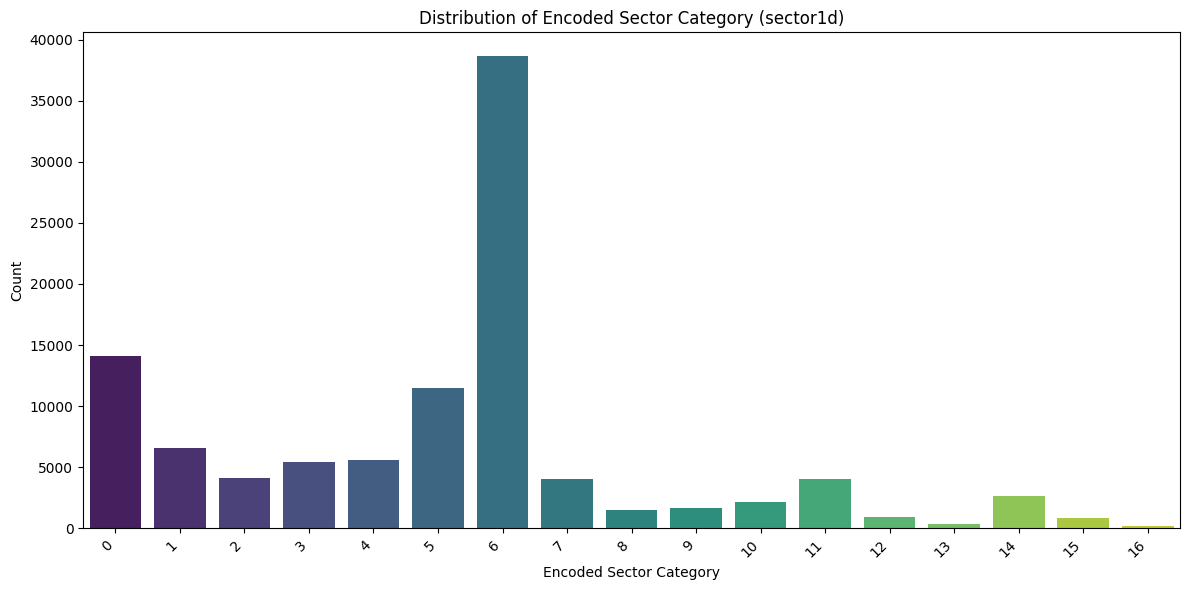

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=train, x='sector1d', palette='viridis')
plt.title('Distribution of Encoded Sector Category (sector1d)')
plt.xlabel('Encoded Sector Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### 1-2. 결측값에서만 poverty 기준이 어떻게 달라지는지 살펴보기

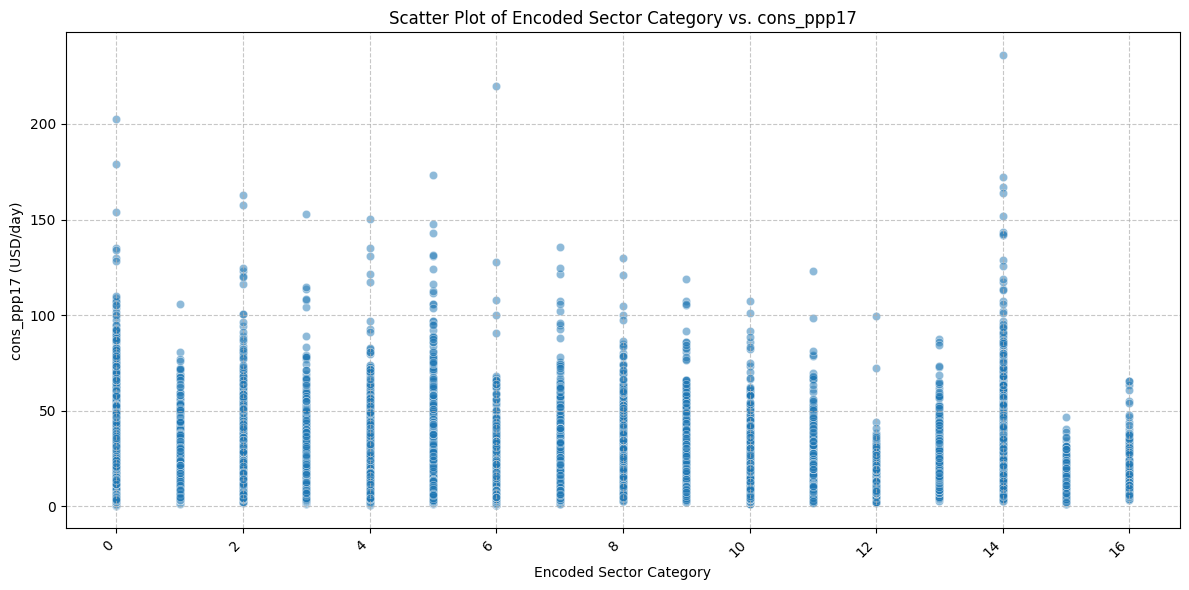

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.scatterplot(data=train, x='sector1d', y='cons_ppp17', alpha=0.5)
plt.title('Scatter Plot of Encoded Sector Category vs. cons_ppp17')
plt.xlabel('Encoded Sector Category')
plt.ylabel('cons_ppp17 (USD/day)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**다른 분포와 크게 다르지 않음. 결측치에도 다양한 사람들이 있는 것 같음. - 고용 여부와 비교해 분포를 둘로 나누기?**

##### 1-3. 고용 여부가 X인 것과 O인 것을 나누어 인코딩

In [ ]:
filtered_data_sector1 = train[train['sector1d'] == 0]
display(filtered_data_sector1['employed'].value_counts(dropna=False))

,count
employed,
Not employed,14084
NaN,45


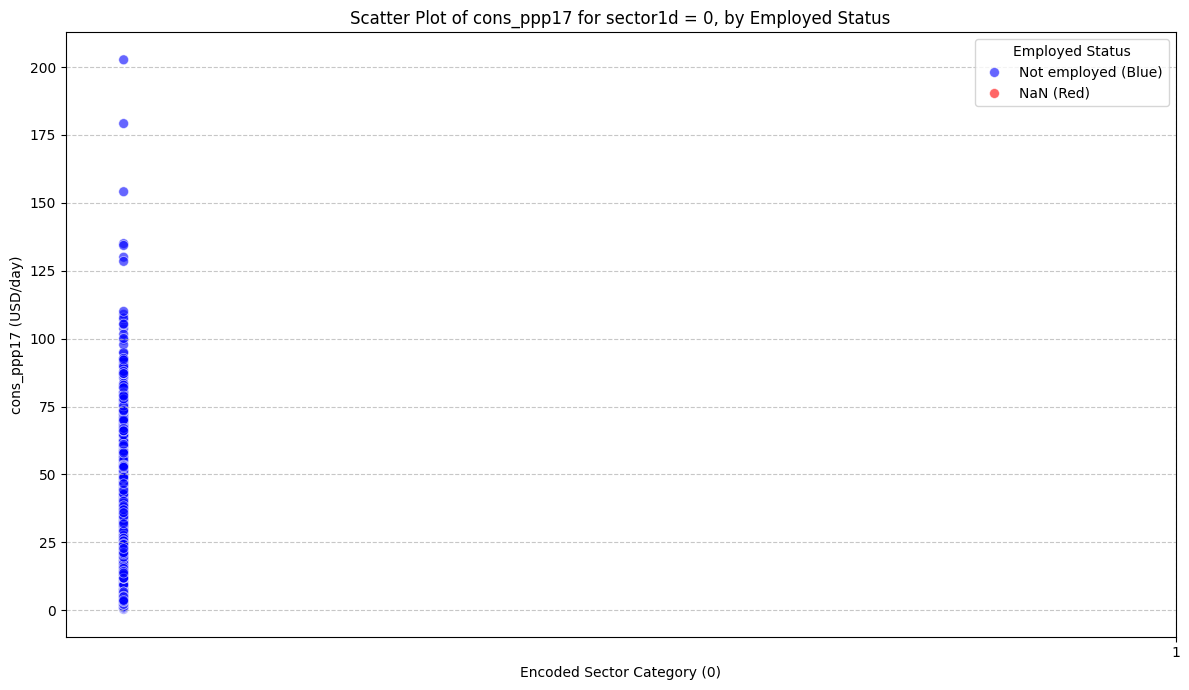

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

filtered_data_sector0 = train[train['sector1d'] == 0].copy()

# Create a category for coloring based on 'employed' status
filtered_data_sector0['employed_status_color'] = 'Other (Employed)'
filtered_data_sector0.loc[filtered_data_sector0['employed'] == 'Not employed', 'employed_status_color'] = 'Not employed (Blue)'
filtered_data_sector0.loc[filtered_data_sector0['employed'].isna(), 'employed_status_color'] = 'NaN (Red)'

# Define a custom color palette
color_palette = {
    'Not employed (Blue)': 'blue',
    'NaN (Red)': 'red',
    'Other (Employed)': 'grey'
}

plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=filtered_data_sector0,
    x='sector1d',
    y='cons_ppp17',
    hue='employed_status_color',
    palette=color_palette,
    alpha=0.6,
    s=50 # size of the points
)
plt.title('Scatter Plot of cons_ppp17 for sector1d = 0, by Employed Status')
plt.xlabel('Encoded Sector Category (0)')
plt.ylabel('cons_ppp17 (USD/day)')
plt.xticks([1]) # Only show the x-tick for 1
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Employed Status')
plt.tight_layout()
plt.show()

**특별히 구분이 되지 않음. Not employed도 돈을 많이 벌 수 있다는 뜻.. 그냥 Nan은 두기로 하자.**

##### >>> 결측값을 포함해 0~16 인코딩

#### dweltyp: 주거 형태

In [ ]:
train.dweltyp.unique()

array(['Detached house', 'Several buildings connected', nan,
       'Separate apartment', 'Other', 'Improvised housing unit'],
      dtype=object)

/tmp/ipython-input-2052107775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dweltyp_with_nan, palette='viridis', order=dweltyp_with_nan.value_counts().index)


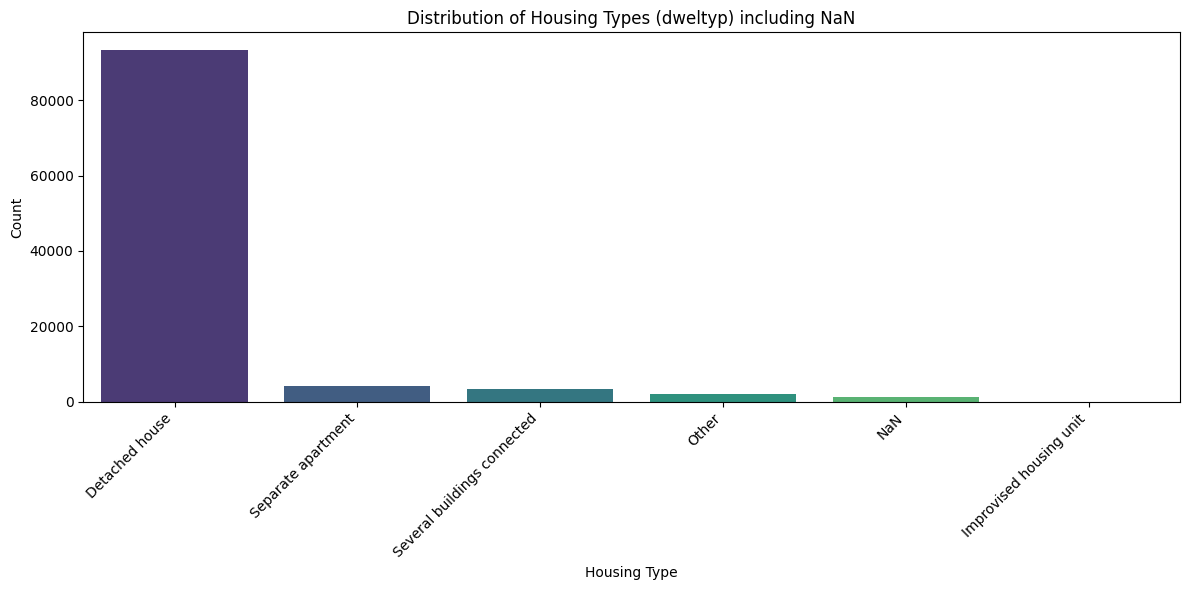

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fill NaN values in 'dweltyp' with a string 'NaN' for plotting
dweltyp_with_nan = train['dweltyp'].fillna('NaN')

plt.figure(figsize=(12, 6))
sns.countplot(x=dweltyp_with_nan, palette='viridis', order=dweltyp_with_nan.value_counts().index)
plt.title('Distribution of Housing Types (dweltyp) including NaN')
plt.xlabel('Housing Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

##### >>> 결측값을 Others에 합치기

In [ ]:
train['dweltyp'] = train['dweltyp'].fillna('Other')
print("Value counts for 'dweltyp' after filling NaN:")
display(train['dweltyp'].value_counts(dropna=False))

Value counts for 'dweltyp' after filling NaN:


,count
dweltyp,
Detached house,93302
Separate apartment,4090
Several buildings connected,3430
Other,3346
Improvised housing unit,66


#### employed: 고용 상태

In [ ]:
train.employed.value_counts()

,count
employed,
Employed,90105
Not employed,14084


##### 3-1. 결측값 확인

In [ ]:
print(train['employed'].isna().sum())

45


**고용 여부가 NaN인 것=전부 sector1d==0인 것**

**이들의 sworkership(고용 형태)를 확인하자**

In [ ]:
nan_employed_sworkershh = train[train['employed'].isna()]['sworkershh']
display(nan_employed_sworkershh.value_counts(dropna=False))

,count
sworkershh,
0.500000,15
0.666667,7
0.333333,5
0.750000,4
0.000000,4
1.000000,3
0.400000,2
0.250000,2
0.200000,1


##### 3-2. 고용 형태만 확인 > 실패!

**숫자가 의미하는 값을 모르겠다..**

In [ ]:
train.sworkershh.value_counts()

,count
sworkershh,
1.000000,54955
0.500000,14457
0.666667,7802
0.000000,6038
1.500000,4764
0.750000,3504
0.333333,3144
2.000000,1917
1.333333,1864


##### 3-3. 결측값만 뽑아서 요소 비교해 보기

In [ ]:
filtered_employed_nan = train[train['employed'].isna()]
display(filtered_employed_nan.head())

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
442,100443,1,660,2,1405.90580,Female,4,0,0,0,...,Yes,Yes,Yes,No,No,Yes,Yes,No,100000,27.682331
664,100665,1,920,2,486.65970,Female,5,1,0,0,...,Yes,No,No,Yes,No,Yes,No,Yes,100000,11.722672
3003,103004,1,2198,5,682.67542,Male,7,1,0,3,...,No,No,No,No,No,Yes,No,No,100000,5.460498
9778,109779,1,1668,1,1534.33000,Female,6,1,2,0,...,No,No,No,Yes,No,No,Yes,No,100000,10.262834
10116,110117,1,4800,1,1040.91100,Female,10,1,3,1,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,100000,4.948198


In [ ]:
display(filtered_employed_nan)

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
442,100443,1,660,2,1405.905800,Female,4,0,0,0,...,Yes,Yes,Yes,No,No,Yes,Yes,No,100000,27.682331
664,100665,1,920,2,486.659700,Female,5,1,0,0,...,Yes,No,No,Yes,No,Yes,No,Yes,100000,11.722672
3003,103004,1,2198,5,682.675420,Male,7,1,0,3,...,No,No,No,No,No,Yes,No,No,100000,5.460498
9778,109779,1,1668,1,1534.330000,Female,6,1,2,0,...,No,No,No,Yes,No,No,Yes,No,100000,10.262834
10116,110117,1,4800,1,1040.911000,Female,10,1,3,1,...,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,100000,4.948198
10293,110294,1,5280,1,1588.403200,Male,11,1,1,1,...,Yes,Yes,Yes,No,Yes,Yes,No,Yes,100000,7.421190
16141,116142,1,572,4,371.753940,Male,2,0,0,0,...,No,No,Yes,No,No,Yes,No,No,100000,15.563122
18565,118566,1,4108,1,973.319400,Female,4,0,0,2,...,Yes,Yes,Yes,Yes,Yes,Yes,No,No,100000,51.536987
19120,119121,1,6024,1,1372.110000,Male,6,0,0,0,...,Yes,No,Yes,No,Yes,Yes,No,No,100000,8.709066
20020,120021,1,1696,1,1723.586400,Female,4,0,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,18.078304


##### >>> 결측값 45개 제거한 뒤 0, 1로 인코딩

In [ ]:
train.dropna(subset=['employed'], inplace=True)
print(f"'employed' 컬럼의 결측값을 제거한 후 train 데이터프레임의 행 수: {len(train)}")

'employed' 컬럼의 결측값을 제거한 후 train 데이터프레임의 행 수: 104189


In [ ]:
train['employed'] = np.where(train['employed'] == 'Employed', 1, 0)
display(train['employed'].value_counts())

,count
employed,
1,90105
0,14084


#### educ_max: 최종 학력

In [ ]:
train.educ_max.value_counts()

,count
educ_max,
Complete Tertiary Education,29387
Complete Secondary Education,24935
Incomplete Tertiary Education,12768
Incomplete Primary Education,11296
Complete Primary Education,11127
Incomplete Secondary Education,10423
Never attended,4231


완전 고등 교육

완전 중등 교육

불완전한 고등 교육

불완전한 초등 교육

완전 초등 교육

불완전한 중등 교육

참석하지 않음

In [ ]:
print(train['educ_max'].isna().sum())

22


##### 4-1. 결측값을 제외한 나머지는 순서에 맞춰 인코딩

0: Never attended / 1: 불완전한 초등 교육 / 2: 완전 초등 교육 / 3: 불완전한 중등 교육 / 4: 완전 중등 교육 / 5: 불완전한 고등 교육 / 6: 완전 고등 교육

In [ ]:
educ_max_mapping = {
    'Never attended': 0,
    'Incomplete Primary Education': 1,
    'Complete Primary Education': 2,
    'Incomplete Secondary Education': 3,
    'Complete Secondary Education': 4,
    'Incomplete Tertiary Education': 5,
    'Complete Tertiary Education': 6
}

train['educ_max'] = train['educ_max'].map(educ_max_mapping)
display(train['educ_max'].value_counts(dropna=False))

,count
educ_max,
6.0,29387
4.0,24935
5.0,12768
1.0,11296
2.0,11127
3.0,10423
0.0,4231
NaN,22


##### 4-2. 최고학력을 알 방법이 없으므로 제거

In [ ]:
train.dropna(subset=['educ_max'], inplace=True)
print(f"'educ_max' 컬럼의 결측값을 제거한 후 train 데이터프레임의 행 수: {len(train)}")

'educ_max' 컬럼의 결측값을 제거한 후 train 데이터프레임의 행 수: 104167


In [ ]:
display(train['educ_max'].value_counts(dropna=False))

,count
educ_max,
6.0,29387
4.0,24935
5.0,12768
1.0,11296
2.0,11127
3.0,10423
0.0,4231


#### consumed: 소비 여부 << 고민

##### `train` 데이터프레임 상태 초기화 및 재전처리

이전에 잘못 인코딩된 'consumed' 컬럼을 복구하기 위해, `train` 데이터프레임을 다시 로드하고 이전 전처리 단계를 재실행합니다.

In [ ]:
# 1. X, y1 데이터 다시 로드 (혹시 모를 변경사항 방지)
X = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_gt.csv')

# 2. X, y1 merge 재실행 (cell EP1Ggw8ZAzau)
train = X.merge(
    y1,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)
print("데이터 병합 완료.")

# 3. sector1d 인코딩 재실행 (cell c69df775)
unique_sectors = train['sector1d'].unique()
sector1d_mapping = {np.nan: 0}
next_val = 1
for sector in unique_sectors:
    if pd.isna(sector):
        continue
    if sector not in sector1d_mapping and sector != 0:
        sector1d_mapping[sector] = next_val
        next_val += 1
train['sector1d'] = train['sector1d'].map(sector1d_mapping).fillna(0)
print("sector1d 인코딩 완료.")

# 4. dweltyp 결측치 처리 재실행 (cell 2192e18a)
train['dweltyp'] = train['dweltyp'].fillna('Other')
print("dweltyp 결측치 처리 완료.")

# 5. employed 결측치 제거 및 인코딩 재실행 (cell aCUz694CuLDt, 259ac08e)
train.dropna(subset=['employed'], inplace=True)
train['employed'] = np.where(train['employed'] == 'Employed', 1, 0)
print("employed 처리 완료.")

# 6. educ_max 인코딩 및 결측치 제거 재실행 (cell ca36b813, tbNkBkRZw7Nb)
educ_max_mapping = {
    'Never attended': 0,
    'Incomplete Primary Education': 1,
    'Complete Primary Education': 2,
    'Incomplete Secondary Education': 3,
    'Complete Secondary Education': 4,
    'Incomplete Tertiary Education': 5,
    'Complete Tertiary Education': 6
}
train['educ_max'] = train['educ_max'].map(educ_max_mapping)
train.dropna(subset=['educ_max'], inplace=True)
print("educ_max 처리 완료.")

# 7. share_secondary 컬럼 제거 재실행 (cell 973aa4d0)
train = train.drop(columns=['share_secondary'])
print("share_secondary 컬럼 제거 완료.")

print("\n'train' 데이터프레임의 상위 5행을 확인하여 복구 상태를 확인합니다:")
display(train.head())

데이터 병합 완료.
sector1d 인코딩 완료.
dweltyp 결측치 처리 완료.
employed 처리 완료.
educ_max 처리 완료.
share_secondary 컬럼 제거 완료.

'train' 데이터프레임의 상위 5행을 확인하여 복구 상태를 확인합니다:


,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
0,100001,1,75,4,594.80627,Female,1,0,0,0,...,No,No,No,Yes,Yes,Yes,Yes,No,100000,25.258402
1,100002,1,150,4,1676.27230,Female,2,0,0,0,...,No,No,No,No,Yes,Yes,No,No,100000,16.996706
2,100003,1,375,4,506.93719,Male,5,0,0,2,...,Yes,No,Yes,Yes,Yes,Yes,No,Yes,100000,13.671848
3,100004,1,375,4,824.61786,Male,5,0,0,1,...,Yes,No,No,No,Yes,Yes,No,No,100000,7.189475
4,100005,1,525,4,351.47644,Male,7,1,0,0,...,No,No,Yes,No,Yes,Yes,Yes,No,100000,12.308855


##### 5-1. `consumed` 컬럼 인코딩

In [ ]:
consumed_cols = [col for col in train.columns if col.startswith('consumed')]

# Map 'Yes' to 1, 'No' to 0
mapping = {'Yes': 1, 'No': 0}

for col in consumed_cols:
    # Check if the column is of object type (contains 'Yes'/'No' or NaN)
    # This prevents errors if the column has already been converted to numeric
    if train[col].dtype == 'object':
        train[col] = train[col].map(mapping).fillna(0).astype(int)
    # If it's already numeric, ensure it's int and fillna in case there were NaNs in numeric form
    else:
        train[col] = train[col].fillna(0).astype(int)

print("'consumed' 컬럼 인코딩 및 결측치 처리 완료.")

# Display value counts for a few 'consumed' columns to verify
print("\n'consumed100' 컬럼 값 분포:")
display(train['consumed100'].value_counts(dropna=False))
print("\n'consumed5000' 컬럼 값 분포:")
display(train['consumed5000'].value_counts(dropna=False))

'consumed' 컬럼 인코딩 및 결측치 처리 완료.

'consumed100' 컬럼 값 분포:


,count
consumed100,
1,95002
0,9165



'consumed5000' 컬럼 값 분포:


,count
consumed5000,
0,81616
1,22551


#### share_secondary: 2차 산업 종사 비율

In [ ]:
train.share_secondary.value_counts()

,count
share_secondary,
0.000000,60419
0.500000,15484
1.000000,8386
0.333333,8260
0.250000,3884
0.666667,3228
0.200000,1278
0.400000,1001
0.750000,706


In [ ]:
print(train['share_secondary'].isna().sum())

0


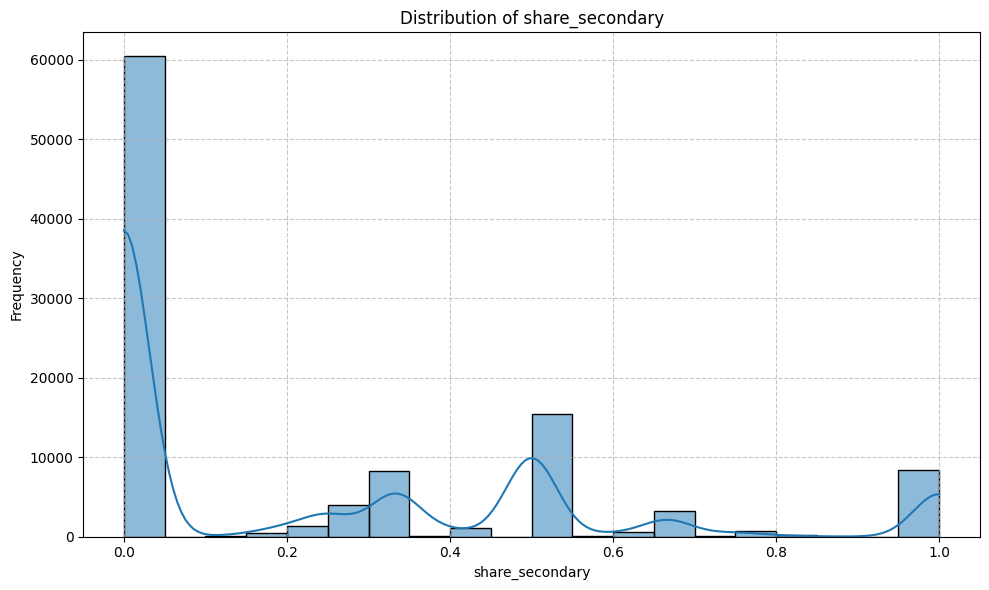

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train['share_secondary'], bins=20, kde=True)
plt.title('Distribution of share_secondary')
plt.xlabel('share_secondary')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### 6-1. 0이라 답한 나머지와 sector1d 비교

In [ ]:
share_secondary_not0=train[train['share_secondary']!=0]
display(share_secondary_not0['sector1d'].value_counts(dropna=False))

,count
sector1d,
6,11545
0,6068
5,5846
1,4129
4,3141
3,3097
11,2067
2,1925
7,1241


6: 농업 수렵 및 임업

0: Nan

5: 도매 및 소매업

1: 운송 보관 및 통신

4: 제조업

3: 건설

##### >>> 그냥 필요없는 자료로 생각하고 삭제

In [ ]:
train = train.drop(columns=['share_secondary'])
print("'share_secondary' 컬럼 제거 후 train 데이터프레임의 컬럼 목록:")
display(train.columns)

'share_secondary' 컬럼 제거 후 train 데이터프레임의 컬럼 목록:


Index(['hhid', 'com', 'weight', 'strata', 'utl_exp_ppp17', 'male', 'hsize',
       'num_children5', 'num_children10', 'num_children18', 'age', 'owner',
       'water', 'toilet', 'sewer', 'elect', 'water_source',
       'sanitation_source', 'dweltyp', 'num_adult_female', 'num_adult_male',
       'num_elderly', 'employed', 'sworkershh', 'educ_max', 'sfworkershh',
       'any_nonagric', 'sector1d', 'region1', 'region2', 'region3', 'region4',
       'region5', 'region6', 'region7', 'urban', 'consumed100', 'consumed200',
       'consumed300', 'consumed400', 'consumed500', 'consumed600',
       'consumed700', 'consumed800', 'consumed900', 'consumed1000',
       'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400',
       'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800',
       'consumed1900', 'consumed2000', 'consumed2100', 'consumed2200',
       'consumed2300', 'consumed2400', 'consumed2500', 'consumed2600',
       'consumed2700', 'consumed2800', 'consumed2900', 'con

#### utl_exp_ppp17: 소비 지출 파생 변수

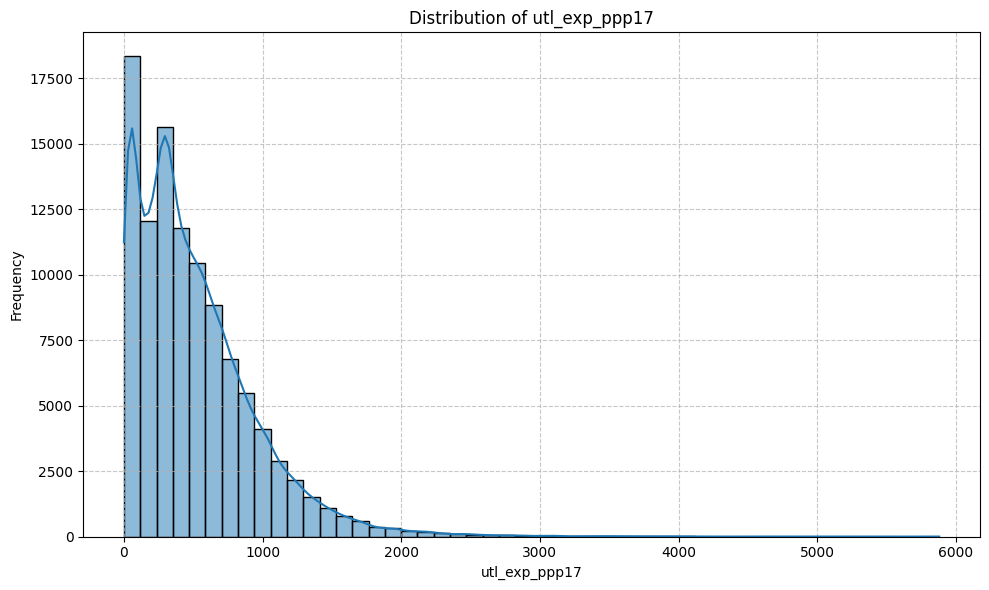

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train['utl_exp_ppp17'], bins=50, kde=True)
plt.title('Distribution of utl_exp_ppp17')
plt.xlabel('utl_exp_ppp17')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
print(train['utl_exp_ppp17'].isna().sum())

85


In [ ]:
print(f"'utl_exp_ppp17' 컬럼의 값이 0인 행의 개수: {len(train[train['utl_exp_ppp17'] == 0])}개")

'utl_exp_ppp17' 컬럼의 값이 0인 행의 개수: 4470개


In [ ]:
display(train[train['utl_exp_ppp17'] == 0].head())

,hhid,com,weight,strata,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,...,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,survey_id,cons_ppp17
31,100032,1,228,8,0.0,Female,3,0,0,0,...,No,No,No,No,No,No,No,No,100000,2.700818
32,100033,1,304,8,0.0,Male,4,1,1,0,...,Yes,No,Yes,No,No,Yes,No,No,100000,3.507676
33,100034,1,532,8,0.0,Male,7,0,1,2,...,No,No,No,No,No,No,No,No,100000,3.030159
34,100035,1,532,8,0.0,Male,7,2,0,3,...,No,No,No,No,No,Yes,No,No,100000,4.248974
36,100037,1,532,8,0.0,Male,7,0,1,3,...,No,No,No,No,No,No,No,No,100000,2.525734


## 전처리 총정리

In [ ]:
import pandas as pd
import numpy as np

# 1. Load 'train_hh_features.csv' into a DataFrame named X and 'train_hh_gt.csv' into a DataFrame named y1.
X = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_features.csv')
y1 = pd.read_csv('/content/drive/MyDrive/Colab/contest/train_hh_gt.csv')

# 2. Merge X and y1 into a new DataFrame called train
train = X.merge(
    y1,
    on=["survey_id", "hhid"],
    how="inner",
    validate="one_to_one"
)
print("Data loaded and merged successfully.")

# 3. Create a mapping for the 'sector1d' column
unique_sectors = train['sector1d'].unique()
sector1d_mapping = {np.nan: 0} # Map NaN to 0
next_val = 1
for sector in unique_sectors:
    if pd.isna(sector):
        continue
    if sector not in sector1d_mapping: # Ensure we don't re-map existing keys
        sector1d_mapping[sector] = next_val
        next_val += 1
train['sector1d'] = train['sector1d'].map(sector1d_mapping).fillna(0.0) # Apply mapping and fill any remaining NaNs
print("'sector1d' column processed.")

# 4. Fill any NaN values in the 'dweltyp' column with the string 'Other'.
train['dweltyp'] = train['dweltyp'].fillna('Other')
print("'dweltyp' column processed.")

# 5. Drop all rows from the train DataFrame where the 'employed' column has a NaN value.
# Then, convert the 'employed' column such that 'Employed' is mapped to 1 and 'Not employed' is mapped to 0.
train.dropna(subset=['employed'], inplace=True)
train['employed'] = np.where(train['employed'] == 'Employed', 1, 0)
print("'employed' column processed.")

# 6. Create an ordinal mapping for the 'educ_max' column
educ_max_mapping = {
    'Never attended': 0,
    'Incomplete Primary Education': 1,
    'Complete Primary Education': 2,
    'Incomplete Secondary Education': 3,
    'Complete Secondary Education': 4,
    'Incomplete Tertiary Education': 5,
    'Complete Tertiary Education': 6
}
train['educ_max'] = train['educ_max'].map(educ_max_mapping)
# After mapping, drop any rows where 'educ_max' is still NaN (for values not in the mapping or original NaNs)
train.dropna(subset=['educ_max'], inplace=True)
print("'educ_max' column processed.")

# 7. Drop the 'share_secondary' column from the train DataFrame.
train = train.drop(columns=['share_secondary'])
print("'share_secondary' column dropped.")

# 8. Identify all columns in the train DataFrame that start with 'consumed'.
consumed_cols = [col for col in train.columns if col.startswith('consumed')]
mapping_yn = {'Yes': 1, 'No': 0}
for col in consumed_cols:
    train[col] = train[col].map(mapping_yn).fillna(0).astype(int)
print("'consumed' columns processed.")

# 9. Calculate the median of the 'utl_exp_ppp17' column and impute any NaN values.
median_utl_exp_ppp17 = train['utl_exp_ppp17'].median()
train['utl_exp_ppp17'] = train['utl_exp_ppp17'].fillna(median_utl_exp_ppp17)
print("'utl_exp_ppp17' column processed.")

print("Preprocessing complete. Displaying first 5 rows of the processed train DataFrame:")
print(train.head().to_markdown(index=False))

Data loaded and merged successfully.
'sector1d' column processed.
'dweltyp' column processed.
'employed' column processed.
'educ_max' column processed.
'share_secondary' column dropped.
'consumed' columns processed.
'utl_exp_ppp17' column processed.
Preprocessing complete. Displaying first 5 rows of the processed train DataFrame:
|   hhid |   com |   weight |   strata |   utl_exp_ppp17 | male   |   hsize |   num_children5 |   num_children10 |   num_children18 |   age | owner     | water   | toilet   | sewer   | elect     | water_source              | sanitation_source    | dweltyp        |   num_adult_female |   num_adult_male |   num_elderly |   employed |   sworkershh |   educ_max |   sfworkershh | any_nonagric   |   sector1d |   region1 |   region2 |   region3 |   region4 |   region5 |   region6 |   region7 | urban   |   consumed100 |   consumed200 |   consumed300 |   consumed400 |   consumed500 |   consumed600 |   consumed700 |   consumed800 |   consumed900 |   consumed1000 |   con

**Reasoning**:
The previous code block successfully applied all the preprocessing steps to the `train` DataFrame. Now, I will display the DataFrame's information (`.info()`) to verify the data types and ensure that all specified NaN values have been handled as instructed.



In [ ]:
print("\nInfo of the processed train DataFrame:")
train.info()


Info of the processed train DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 104167 entries, 0 to 104233
Data columns (total 88 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   hhid               104167 non-null  int64  
 1   com                104167 non-null  int64  
 2   weight             104167 non-null  int64  
 3   strata             104167 non-null  int64  
 4   utl_exp_ppp17      104167 non-null  float64
 5   male               104167 non-null  object 
 6   hsize              104167 non-null  int64  
 7   num_children5      104167 non-null  int64  
 8   num_children10     104167 non-null  int64  
 9   num_children18     104167 non-null  int64  
 10  age                104167 non-null  int64  
 11  owner              104167 non-null  object 
 12  water              104167 non-null  object 
 13  toilet             104167 non-null  object 
 14  sewer              104167 non-null  object 
 15  elect           

## 시각화

In [ ]:
train['sector1d'].value_counts().sort_values()

,count
sector1d,
16,219
13,345
15,838
12,956
8,1488
9,1669
10,2120
14,2618
7,3995
